In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE, F1_metric
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Split on test, train, validation

In [4]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: 
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


## New model

In [5]:
batch_size=20 
num_channels=4

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = True              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = False     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided

generator.lidar_coef = 2.5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 2    # target resolution both for height and imagery
generator.clip_value = 40.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

In [6]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [11]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

nb_name = 'regr_rgb_nir_wv.ipynb'

save_file = nb_name.split('.')[0] + '.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

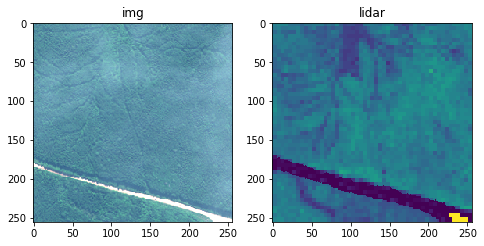

In [16]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Text(0.5,1,'lidar')

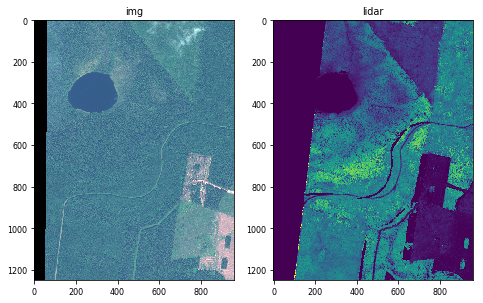

In [57]:
generator.augm = False
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False
generator.augm = True   

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set model

In [7]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [8]:
model_name = 'regr_rgb_nir_wv'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [35]:
history=model.fit_generator(generator.train_gen(),epochs=25, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/25
200/200 [==============================] - 165s 825ms/step - loss: 0.1417 - rmse: 0.1417 - val_loss: 0.3632 - val_rmse: 0.3632

Epoch 00001: val_loss improved from inf to 0.36321, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_nir_wv.h5

Epoch 00001: val_loss improved from inf to 0.36321, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_nir_wv.hdf5
Epoch 2/25
200/200 [==============================] - 134s 669ms/step - loss: 0.1314 - rmse: 0.1314 - val_loss: 0.1687 - val_rmse: 0.1687

Epoch 00002: val_loss improved from 0.36321 to 0.16867, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_nir_wv.h5

Epoch 00002: val_loss improved from 0.36321 to 0.16867, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_nir_wv.hdf5
Epoch 3/25
200/200 [==============================] - 132s 662ms/step - loss: 0.1255 - rmse:

KeyboardInterrupt: 

In [9]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Evaluation

In [37]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[0])
generator.augm  = True

Text(0.5,1,'lidar')

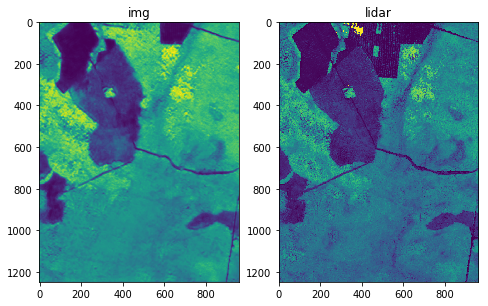

In [38]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [39]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 4.699
MAE 2.861


In [10]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )
generator.augm  = True

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.699  mae:  2.861  r2:  0.555  mbe:  -0.38774473445488133
1 rmse:  3.296  mae:  2.414  r2:  0.673  mbe:  -0.8216372540017349
2 rmse:  4.314  mae:  3.192  r2:  0.738  mbe:  -0.6534174498356498
3 rmse:  4.195  mae:  3.132  r2:  0.438  mbe:  -0.7819234858988178
~~~~~~~~~~~~~~~~
Average RMSE:  4.126
Average MAE:  2.9
Average R2:  0.601
Average mean bias:  -0.661


In [11]:
num_cl = 4
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

0 : precision  0.76  recall  0.457  f1  0.571
 
1 : precision  0.59  recall  0.534  f1  0.561
 
2 : precision  0.79  recall  0.943  f1  0.86
 
3 : precision  0.666  recall  0.417  f1  0.513
 
0 : precision  0.592  recall  0.632  f1  0.611
 
1 : precision  0.626  recall  0.396  f1  0.485
 
2 : precision  0.809  recall  0.945  f1  0.872
 
3 : precision  0.554  recall  0.174  f1  0.264
 
0 : precision  0.83  recall  0.747  f1  0.787
 
1 : precision  0.384  recall  0.228  f1  0.286
 
2 : precision  0.61  recall  0.736  f1  0.667
 
3 : precision  0.665  recall  0.598  f1  0.63
 
0 : precision  0.871  recall  0.199  f1  0.324
 
1 : precision  0.223  recall  0.058  f1  0.093
 
2 : precision  0.78  recall  0.847  f1  0.812
 
3 : precision  0.602  recall  0.554  f1  0.577
 


In [12]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.57315965 0.35616815 0.80264945 0.49615306]
0.5570325765783835


# Save prediction

In [ ]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [39]:
val_img_list

['/home/user/data/krasnoborsk/world_view/0/6_3',
 '/home/user/data/krasnoborsk/world_view/0/2_2',
 '/home/user/data/krasnoborsk/world_view/0/4_2',
 '/home/user/data/krasnoborsk/world_view/0/1_1']

In [53]:
generator.augm  = False
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    height_name = '/home/user/data/krasnoborsk/world_view/0/height_6_3.tif'
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img=height_name, crs=4326)
    tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')
    break
generator.augm  = True

1918 2498 (1249, 959)


In [54]:
tmp = tiff.imread('../images/tmp.tif')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fa0bc531358>)

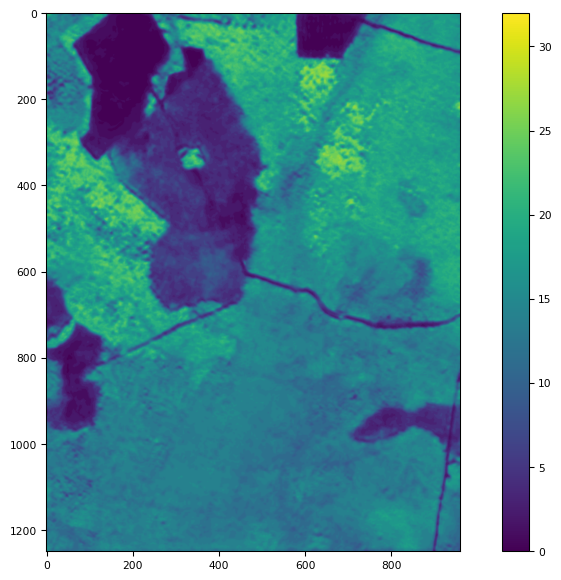

In [55]:
tiff.imshow(tmp.clip(0, 40))

In [56]:
tmp = tiff.imread(height_name)
tmp.shape

(2498, 1918)